In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# to output everything in a cell instead of only the last output

%matplotlib inline

# standard imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import keras

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"Keras backend: {keras.backend.backend()}")
print(f"\nGPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")

# List all devices
print("\nAll available devices:")
for device in tf.config.list_physical_devices():
    print(f"  {device.device_type}: {device.name}")

# Test GPU computation
if tf.config.list_physical_devices('GPU'):
    print("\n✓ GPU is available and will be used for training")
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
        b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
        c = tf.matmul(a, b)
    print(f"Test computation on GPU successful: {c.numpy()}")
else:
    print("\n⚠ No GPU detected - training will use CPU (slower)")

2025-12-27 17:32:42.380103: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-27 17:32:42.429834: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-27 17:32:43.937979: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow version: 2.20.0
Keras version: 3.12.0
Keras backend: tensorflow

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True

All available devices:
  CPU: /physical_device:CPU:0
  GPU: /physical_device:GPU:0

✓ GPU is available and will be used for training
Test computation on GPU successful: [[1. 3.]
 [3. 7.]]


I0000 00:00:1766827964.651002  129872 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13689 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


## import data

In [22]:
from pathlib import Path

# Configure where the .npy data files live.
# If your data is in a different folder (e.g., ../Data), change DATA_DIR below.
DATA_DIR = Path('data')

train_ssh_path = DATA_DIR / 'trainAVISO-SSH_2000-2010.npy'
train_seg_path = DATA_DIR / 'trainSegmentation_2000-2010.npy'
test_ssh_path  = DATA_DIR / 'testAVISO-SSH_2011.npy'
test_seg_path  = DATA_DIR / 'testSegmentation_2011.npy'

missing = [p.name for p in [train_ssh_path, train_seg_path, test_ssh_path, test_seg_path] if not p.exists()]
print(f"Data directory: {DATA_DIR.resolve()}")
if missing:
    print("Missing files:", missing)
    print("Tip: copy the files into this folder or set DATA_DIR to the correct path (e.g., Path('../Data')).")
else:
    print("All required files present.")

Data directory: /home/pychang/ai_dev/EddyNet/EddyNet_new/data
All required files present.


In [4]:
# Load data using configured paths; handle missing training files gracefully.
import numpy as np

HAS_TRAIN = train_ssh_path.exists() and train_seg_path.exists()

if not HAS_TRAIN:
    print("Warning: Training files not found.")
    # Fallback: use test files for inference-only runs
    if not test_ssh_path.exists() or not test_seg_path.exists():
        raise FileNotFoundError("Test .npy files also missing. Please set DATA_DIR correctly or place files next to the notebook.")

SSH_train = np.expand_dims(np.load(str(train_ssh_path if HAS_TRAIN else test_ssh_path)), 3)[:,25:168+25,280-168:,:]
SSH_test  = np.expand_dims(np.load(str(test_ssh_path)), 3)[:,25:168+25,280-168:,:]
######
Seg_train = np.expand_dims(np.load(str(train_seg_path if HAS_TRAIN else test_seg_path)), 3)[:,25:168+25,280-168:,:]
Seg_test  = np.expand_dims(np.load(str(test_seg_path)), 3)[:,25:168+25,280-168:,:]
######
print({"HAS_TRAIN": HAS_TRAIN, "train_samples": SSH_train.shape[0], "test_samples": SSH_test.shape[0]})
SSH_train.shape
SSH_test.shape
#####
Seg_train.shape
Seg_test.shape

{'HAS_TRAIN': True, 'train_samples': 4018, 'test_samples': 365}


(4018, 168, 168, 1)

(365, 168, 168, 1)

(4018, 168, 168, 1)

(365, 168, 168, 1)

<Figure size 2000x1000 with 0 Axes>

<Axes: >

(np.float64(-0.5), np.float64(167.5), np.float64(167.5), np.float64(-0.5))

Text(0.5, 1.0, 'SSH')

<Axes: >

(np.float64(-0.5), np.float64(167.5), np.float64(167.5), np.float64(-0.5))

Text(0.5, 1.0, 'ground truth Segmentation')

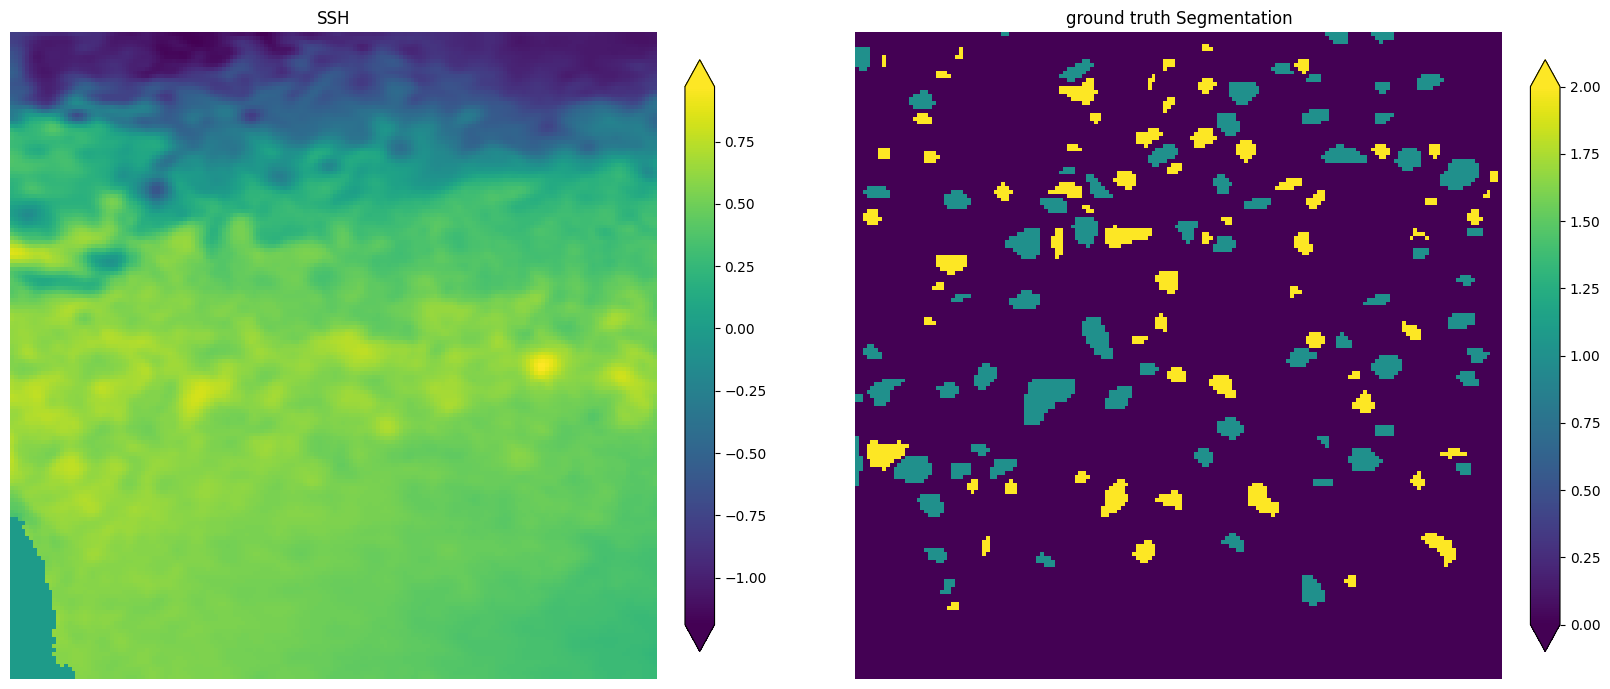

In [5]:
randindex = np.random.randint(0, len(SSH_train))

plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.imshow(SSH_train[randindex, :, :, 0], cmap="viridis")
plt.colorbar(extend="both", fraction=0.042, pad=0.04)
# plt.clim(-0.25,0.25)
plt.axis("off")
plt.title("SSH")

plt.subplot(122)
plt.imshow(Seg_train[randindex, :, :, 0], cmap="viridis")
plt.colorbar(extend="both", fraction=0.042, pad=0.04)
# plt.clim(-0.25,0.25)
plt.axis("off")
plt.title("ground truth Segmentation")

## Eddynet 

In [6]:
from keras.models import Model, load_model
from keras.layers import Activation, Reshape, Permute, Lambda
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, AlphaDropout, concatenate, Conv2DTranspose
from keras.layers import BatchNormalization, LeakyReLU, add
from keras.utils import to_categorical  # np_utils is deprecated
from keras.optimizers import Adam
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
import pickle
from IPython.display import SVG 
from keras.utils import model_to_dot  # use model_to_dot directly
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

In [7]:
# Build per-pixel categorical labels for training (or fallback), with dynamic sample count.
from keras.utils import to_categorical
num_samples = Seg_train.shape[0]
Seg_train_categor = to_categorical(np.reshape(Seg_train[:,:,:,0], (num_samples, 168*168)), 3)
Seg_train_categor.shape

(4018, 28224, 3)

In [8]:
def ConvBNActi(nf,ker,inputs):
    conv1 = Conv2D(nf, ker, padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    #conv1 = LeakyReLU(0.3)(conv1)
    return conv1
  
def ConvTranspBNActi(nf,ker,inputs):
    conv1 = Conv2DTranspose(nf, ker, strides=(2, 2), padding="same", kernel_initializer='he_normal', use_bias=False)(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    #conv1 = LeakyReLU(0.3)(conv1)
    return conv1

In [9]:
width = 168
height = 168
nbClass = 3
nf = 16
ker = 3

###################################### INPUT LAYER

img_input = Input(shape=(height, width, 1))
######################################ENCODER

conv1 = ConvBNActi(nf,ker,img_input)
conv1 = ConvBNActi(nf,ker,conv1)
conv1 = Dropout(0.2)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = ConvBNActi(nf,ker,pool1)
conv2 = ConvBNActi(nf,ker,conv2)
conv2 = Dropout(0.3)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = ConvBNActi(nf,ker,pool2)
conv3 = ConvBNActi(nf,ker,conv3)
conv3 = Dropout(0.4)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#######################################center

convC = ConvBNActi(nf,ker,pool3)
convC = ConvBNActi(nf,ker,convC)
convC = Dropout(0.5)(convC)

#######################################DECODER

#up3 = concatenate([ConvTranspBNActi(nf,ker,convC), conv3])
up3 = concatenate([UpSampling2D((2,2))(convC), conv3])
decod3 = ConvBNActi(nf,ker,up3)
decod3 = ConvBNActi(nf,ker,decod3)
decod3 = Dropout(0.4)(decod3)



#up2 = concatenate([ConvTranspBNActi(nf,ker,decod3), conv2])
up2 = concatenate([UpSampling2D((2,2))(decod3), conv2])
decod2 = ConvBNActi(nf,ker,up2)
decod2 = ConvBNActi(nf,ker,decod2)
decod2 = Dropout(0.3)(decod2)


#up1 = concatenate([ConvTranspBNActi(nf,ker,decod2), conv1])
up1 = concatenate([UpSampling2D((2,2))(decod2), conv1])
decod1 = ConvBNActi(nf,ker,up1)
decod1 = ConvBNActi(nf,ker,decod1)
decod1 = Dropout(0.2)(decod1)


####################################### Segmentation Layer

x = Conv2D(nbClass, (1, 1), padding="valid", use_bias=False)(decod1) 
x = Reshape((height * width, nbClass))(x) 
x = Activation("softmax")(x)
eddynet = Model(img_input, x)

eddynet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 168, 168,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 168, 168,  │        144 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 168, 168,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 168, 168,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 168, 168,  │      2,304 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 168, 168,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 168, 168,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 168, 168,  │          0 │ activation_1[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 84, 84,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 84, 84,    │      2,304 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 84, 84,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 84, 84,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 84, 84,    │      2,304 │ activation_2[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 84, 84,    │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 84, 84,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 84, 84,    │          0 │ activation_3[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 42, 42,    │          0 │ dropout_1[0][0] 

 Total params: 37,952 (148.25 KB)

 Trainable params: 37,504 (146.50 KB)

 Non-trainable params: 448 (1.75 KB)

### calculate weights (some heavy data imbalance out there...)

In [10]:
unique, counts = np.unique(Seg_train, return_counts=True)
dict(zip(unique, counts))

{np.int64(0): np.int64(100434896),
 np.int64(1): np.int64(8225760),
 np.int64(2): np.int64(4743376)}

In [11]:
freq = [np.sum(counts)/j for j in counts]
weightsSeg = [f/np.sum(freq) for f in freq]
weightsSeg

[np.float64(0.02908370281349848),
 np.float64(0.35510623545649606),
 np.float64(0.6158100617300055)]

## loss functions

In [12]:
import keras.ops as ops

smooth = 1.  # to avoid zero division

def dice_coef_anti(y_true, y_pred):
    y_true_anti = y_true[:,:,1]
    y_pred_anti = y_pred[:,:,1]
    intersection_anti = ops.sum(y_true_anti * y_pred_anti)
    return (2 * intersection_anti + smooth) / (ops.sum(y_true_anti) + ops.sum(y_pred_anti) + smooth)

def dice_coef_cyc(y_true, y_pred):
    y_true_cyc = y_true[:,:,2]
    y_pred_cyc = y_pred[:,:,2]
    intersection_cyc = ops.sum(y_true_cyc * y_pred_cyc)
    return (2 * intersection_cyc + smooth) / (ops.sum(y_true_cyc) + ops.sum(y_pred_cyc) + smooth)

def dice_coef_nn(y_true, y_pred):
    y_true_nn = y_true[:,:,0]
    y_pred_nn = y_pred[:,:,0]
    intersection_nn = ops.sum(y_true_nn * y_pred_nn)
    return (2 * intersection_nn + smooth) / (ops.sum(y_true_nn) + ops.sum(y_pred_nn) + smooth)
    
def mean_dice_coef(y_true, y_pred):
    return (dice_coef_anti(y_true, y_pred) + dice_coef_cyc(y_true, y_pred) + dice_coef_nn(y_true, y_pred))/3.

def weighted_mean_dice_coef(y_true, y_pred):
    return (0.36*dice_coef_anti(y_true, y_pred) + 0.62*dice_coef_cyc(y_true, y_pred) + 0.02*dice_coef_nn(y_true, y_pred))
  
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_mean_dice_coef(y_true, y_pred)

# Compile Network

In [13]:
eddynet.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_coef_loss,
                metrics=['categorical_accuracy', mean_dice_coef, weighted_mean_dice_coef])

# Plot Network Architecture

In [14]:
from keras.utils import plot_model
plot_model(eddynet, to_file="eddynet.png", show_shapes=True, expand_nested=True)

In [15]:
# import shutil
# import pydot

# # Ensure Graphviz's `dot` binary is available; `pydot` alone is not enough.
# dot_path = shutil.which("dot")
# print(f"pydot version: {pydot.__version__}")
# print(f"graphviz dot in PATH: {dot_path}")

# if dot_path:
#     SVG(model_to_dot(eddynet).create(prog='dot', format='svg'))
# else:
#     print("Graphviz `dot` not found. Install it (e.g., `sudo apt-get install graphviz`) and restart the kernel, then rerun this cell.")


## Training

In [16]:
modelcheck = ModelCheckpoint('./weights/eddynetfirst.weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
reducecall = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)

if HAS_TRAIN:
    histeddynet = eddynet.fit(SSH_train, Seg_train_categor,
                              epochs=50,
                              batch_size=16,
                              shuffle=True,
                              verbose=1,
                              callbacks=[modelcheck, reducecall],
                              validation_split=0.2)
else:
    print("Skipping training: HAS_TRAIN is False (using test data for inference-only).")

Epoch 1/50


2025-12-27 17:33:11.057860: I external/local_xla/xla/service/service.cc:163] XLA service 0x780160014bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-27 17:33:11.057917: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-12-27 17:33:11.475124: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-27 17:33:12.502250: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701


  2/201 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - categorical_accuracy: 0.3987 - loss: 0.8984 - mean_dice_coef: 0.2474 - weighted_mean_dice_coef: 0.1016 

I0000 00:00:1766828001.937674  130003 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - categorical_accuracy: 0.5374 - loss: 0.7476 - mean_dice_coef: 0.3743 - weighted_mean_dice_coef: 0.2524
Epoch 1: val_loss improved from None to 0.80511, saving model to ./weights/eddynetfirst.weights.h5
201/201 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - categorical_accuracy: 0.6518 - loss: 0.6616 - mean_dice_coef: 0.4619 - weighted_mean_dice_coef: 0.3385 - val_categorical_accuracy: 0.8404 - val_loss: 0.8051 - val_mean_dice_coef: 0.4401 - val_weighted_mean_dice_coef: 0.1948 - learning_rate: 0.0010
Epoch 2/50
199/201 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8634 - loss: 0.5107 - mean_dice_coef: 0.6241 - weighted_mean_dice_coef: 0.4893
Epoch 2: val_loss improved from 0.80511 to 0.67082, saving model to ./weights/eddynetfirst.weights.h5
201/201 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - categorical_accuracy: 0.8730 - loss: 0.4937 - mean_dice_coef: 0.6393 - weighted_mean_dice_coef: 0.5063 - val_categorical_accuracy: 0.8886 - val_loss: 0.6708 

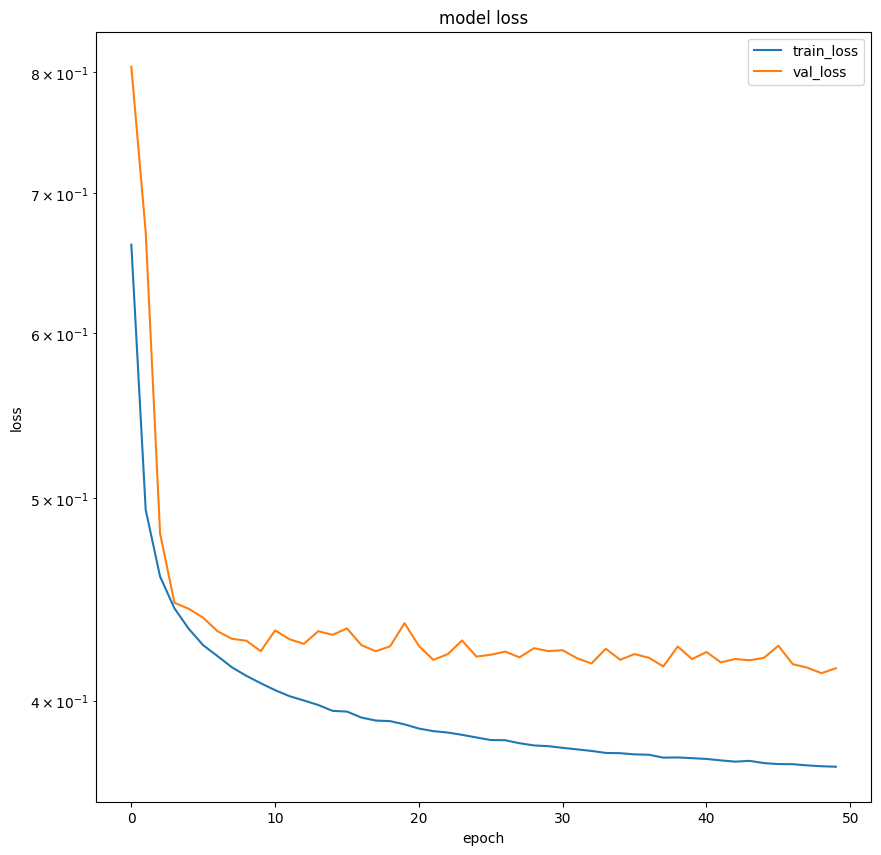

In [17]:
plt.figure(figsize=(10, 10))
plt.semilogy(eddynet.history.history['loss'])
plt.semilogy(eddynet.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right');

overfitting, huh?... I'm working on that on my next paper, stay tuned! meanwhile for your application you can either get more data or lower the complexity of the architecture (less neurons, less depth..) 

## Performance on train dataset 
just to be sure...

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


<Figure size 2000x1000 with 0 Axes>

<Axes: >

(np.float64(-0.5), np.float64(167.5), np.float64(167.5), np.float64(-0.5))

Text(0.5, 1.0, 'SSH')

<Axes: >

(np.float64(-0.5), np.float64(167.5), np.float64(167.5), np.float64(-0.5))

Text(0.5, 1.0, 'Eddynet Segmentation')

<Axes: >

(np.float64(-0.5), np.float64(167.5), np.float64(167.5), np.float64(-0.5))

Text(0.5, 1.0, 'ground truth Segmentation')

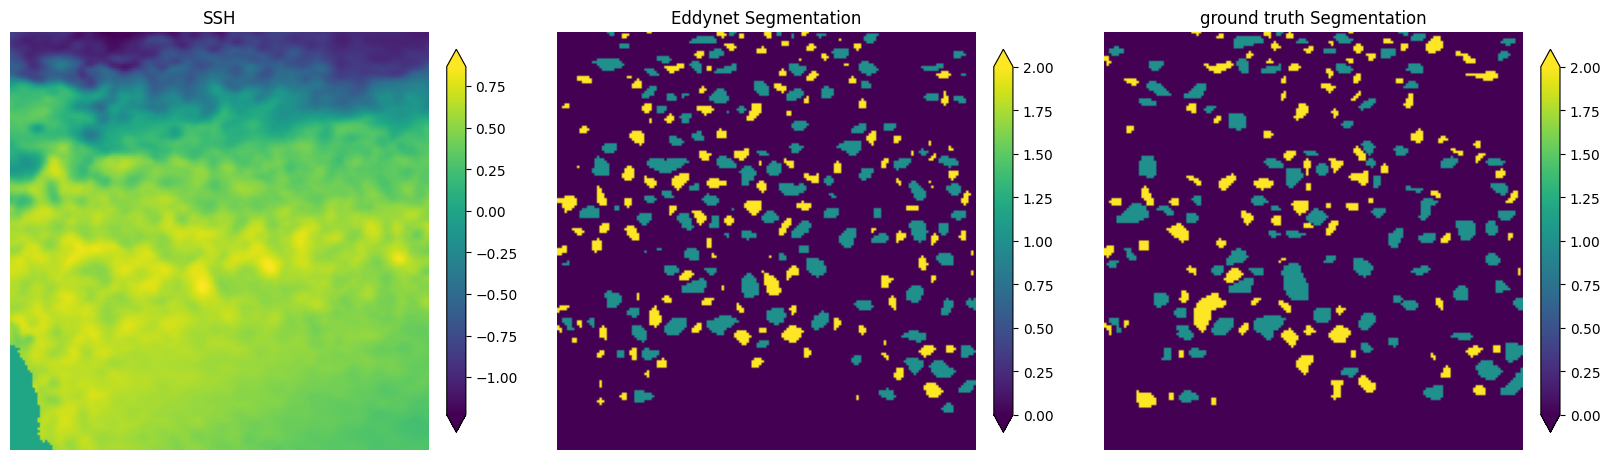

In [18]:
if HAS_TRAIN:
    randindex = np.random.randint(0, len(SSH_train))
    predictedSEGM = eddynet.predict(np.reshape(SSH_train[randindex,:,:], (1, height, width, 1)))
    predictedSEGMimage = np.reshape(predictedSEGM.argmax(2), (height, width))

    plt.figure(figsize=(20, 10))

    plt.subplot(131)
    plt.imshow(SSH_train[randindex,:,:,0], cmap='viridis')
    plt.colorbar(extend='both', fraction=0.042, pad=0.04)
    plt.axis('off')
    plt.title('SSH');

    plt.subplot(132)
    plt.imshow(predictedSEGMimage, cmap='viridis')
    plt.colorbar(extend='both', fraction=0.042, pad=0.04)
    plt.axis('off')
    plt.title('Eddynet Segmentation');

    plt.subplot(133)
    plt.imshow(Seg_train[randindex,:,:,0], cmap='viridis')
    plt.colorbar(extend='both', fraction=0.042, pad=0.04)
    plt.axis('off')
    plt.title('ground truth Segmentation');
else:
    print('Skipping train dataset performance plot: HAS_TRAIN is False.')

## Performance on test dataset (2011 data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


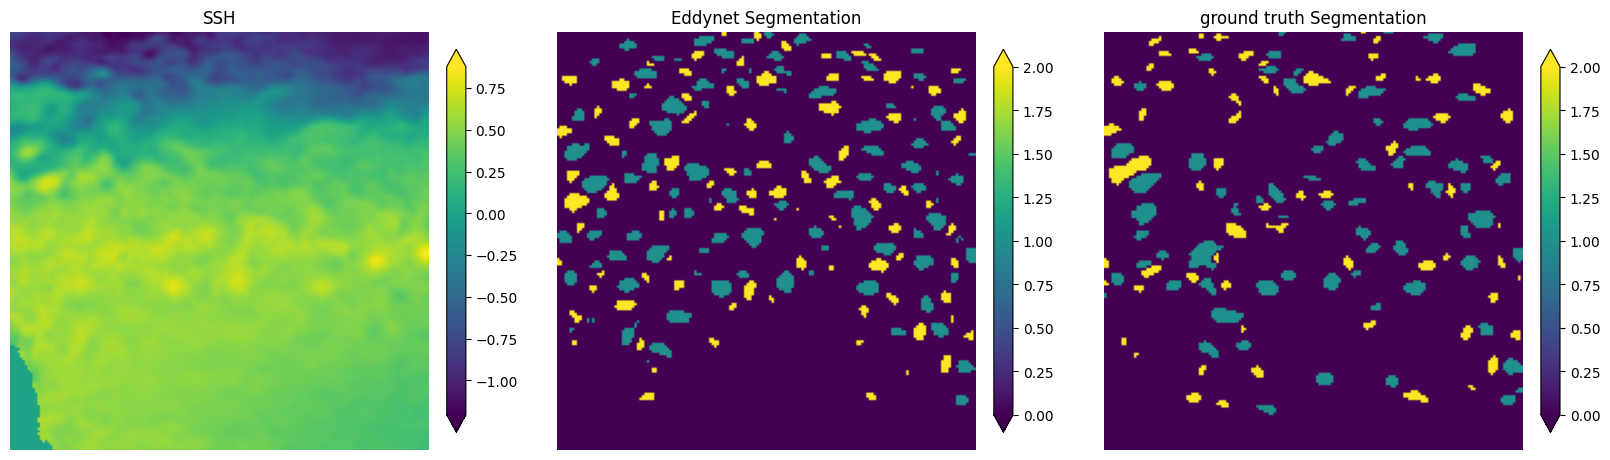

In [19]:
randindex=np.random.randint(0,len(SSH_test))
predictedSEGM=eddynet.predict(np.reshape(SSH_test[randindex,:,:],(1,height,width,1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(height,width))

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(SSH_test[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SSH');

plt.subplot(132)
plt.imshow(predictedSEGMimage, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('Eddynet Segmentation');

plt.subplot(133)
plt.imshow(Seg_test[randindex,:,:,0], cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

Seems working nicely, but there are some false eddy detections that need to be dealt with, working on it..

In [20]:
#### if you wanna use some animations ;) 


#imageList=[]
#for i in range(1200,1400):
#    imageList.append(SSH_train[i,:,:,0])
  

#print('drawing the animation...')
#from matplotlib import animation, rc
#from IPython.display import HTML

#def getImageFromList(x):
#    return imageList[x]

#fig = plt.figure(figsize=(10, 10))
#ims = []
#for i in range(len(imageList)):
#    im = plt.imshow(getImageFromList(i), animated=True, cmap='viridis')
#    ims.append([im])
#plt.axis('off')

#ani = animation.ArtistAnimation(fig, ims, interval=50, blit=False, repeat=False)
#plt.close()

#HTML(ani.to_jshtml())